## Context

Congratulations! You have just been hired as a data scientist at [FC Tokyo, a J1 League Japanese professional football club based in Chōfu, Tokyo](https://en.wikipedia.org/wiki/FC_Tokyo). The company hired you to carry out a variety of data-related tasks, which will be explained in further detail below.

Your manager, Mr. Naoki Ogane, has noticed that an unusually high number of players in your team have birthdays in either April or May, so he asked you to investigate this further -- is this just a coincidence, or are players born in April or May simply better?

## Data

To answer Mr. Ogane's questions, you will use data from Wikipedia biographies. This is a subset of the Pantheon dataset (1). For tasks 1 to 4, you will use the file `japanese_athletes.csv.gz`. For task 5, you will use the file `all_entities.csv.gz`. Both datasets are`.csv` files with the same columns:

- `id`: a unique identifier per individual.
- `name`: name of the individual.
- `occupation`: the occupation of the individual (for `japanese_athletes.csv.gz`, these are all sports-related).
- `gender`: gender of the athlete.
- `alive`: flag indicating if the athlete was alive in 2020 when the dataset was collected.
- `bplace_country`: the country where the athlete was born  (for `japanese_athletes.csv.gz`, the value here is always 'Japan').
- `birthdate`: the date when the athlete was born.
- `birthyear`: the year when the athlete was born.
- `pageviews`: number of pageviews received by the athlete's page across Wikipedia language editions.

(1) Yu, A. Z., et al. (2016). Pantheon 1.0, a manually verified dataset of globally famous biographies. Scientific Data 2:150075. doi: 10.1038/sdata.2015.75

In [22]:
# Imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate as tb
from scipy.stats.mstats import gmean
from scipy.stats import bootstrap
import statsmodels.formula.api as smf
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from causalgraphicalmodels import CausalGraphicalModel


# Constants
DATA_DIR = "data/"
JAPANESE_ATHLETES_FILENAME = "japanese_athletes.csv.gz"
ALL_ATHLETES_FILENAME = "all_entities.csv.gz"

### Task 1.1
Load the dataset containing data about Japanese athletes into memory using pandas. First, load the data directly from the compressed file. Then, print the first few lines of the dataset.

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, JAPANESE_ATHLETES_FILENAME), compression='gzip', parse_dates=['birthdate'])
df.head(10)

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews
0,25864486,Hisataka Okamoto,SOCCER PLAYER,M,True,Japan,1933-12-14,1933.0,455.0
1,1682054,Kunishige Kamamoto,SOCCER PLAYER,M,True,Japan,1944-04-15,1944.0,57847.0
2,20639249,Akira Kitaguchi,SOCCER PLAYER,M,True,Japan,1935-03-08,1935.0,759.0
3,20641463,Tsukasa Hosaka,SOCCER PLAYER,M,False,Japan,1937-03-03,1937.0,1672.0
4,25864343,Takashi Kasahara,SOCCER PLAYER,M,True,Japan,1918-03-26,1918.0,541.0
5,20641239,Yasuo Takamori,SOCCER PLAYER,M,False,Japan,1934-03-03,1934.0,1047.0
6,25864509,Yozo Aoki,SOCCER PLAYER,M,False,Japan,1929-04-10,1929.0,726.0
7,25864493,Yasukazu Tanaka,SOCCER PLAYER,M,True,Japan,1933-06-15,1933.0,468.0
8,25864226,Saizo Saito,SOCCER PLAYER,M,False,Japan,1908-09-24,1908.0,603.0
9,20640290,Hiroaki Sato,SOCCER PLAYER,M,False,Japan,1932-02-05,1932.0,883.0


### Task 1.2

Find the different occupations in the data and how many individuals belong to each occupation.

In [11]:
# Get different occupations
occupations = df.occupation.unique()

# Get number of individuals for each occupation
individuals_per_occupation = df.groupby(by='occupation').id.count()

print(tb.tabulate(zip(occupations, individuals_per_occupation.loc[occupations].values), headers=["Distinct occupation", "Number of athletes"]))
      

Distinct occupation      Number of athletes
---------------------  --------------------
SOCCER PLAYER                          3929
WRESTLER                                 60
ATHLETE                                  40
GYMNAST                                  15
SKIER                                    11
SWIMMER                                  21
SKATER                                   21
CYCLIST                                   4
TENNIS PLAYER                            18
BASKETBALL PLAYER                         2
BOXER                                     2


### Task 1.3
Calculate the percentage of individuals who remain alive in the data.

In [15]:
# Get the number of alive individuals
nr_alive = len(df[df.alive])

# Get the total number of individuals
nr_all = len(df)

print("The percentage of individuals who remain alive is {:.2f}%".format(nr_alive * 100 / nr_all))

The percentage of individuals who remain alive is 97.19%


### Task 1.4
 Plot the distribution of birth years in the dataset. In other words, what fraction of individuals are born each year? (Note that the data contains individuals born only after the year 1900).

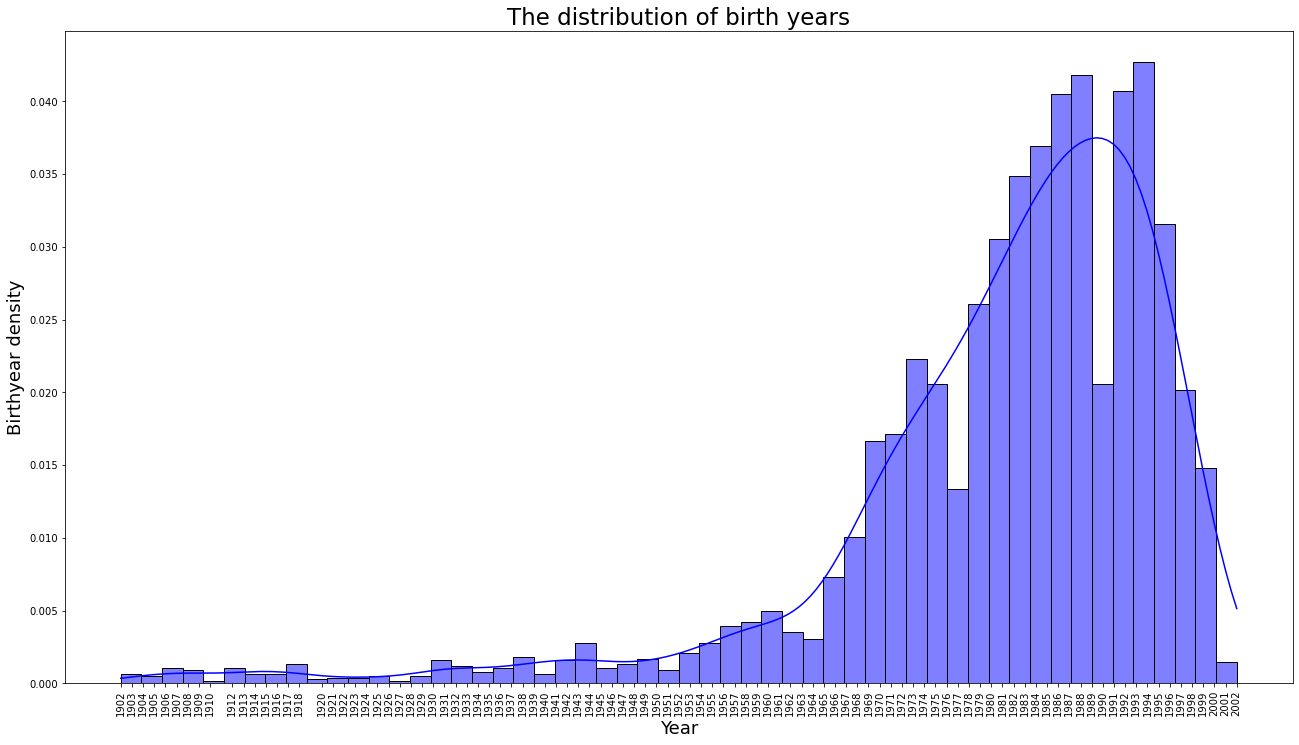

In [22]:
fig, ax = plt.subplots(1, figsize=(22, 12))
ax = sns.histplot(df['birthdate'].dt.year, kde=True, stat='density', color='blue',)

plt.xticks(ticks=np.sort(df['birthdate'].dt.year.unique()),rotation=90)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel("Birthyear density", fontsize=18)
ax.set_title('The distribution of birth years', fontsize=23)
plt.show()

### Task 1.5
Plot the empirical cumulative distribution function (CDF) to visualize the distribution of pageviews. Here you should use a linear scale for both the x-axis and the y-axis.


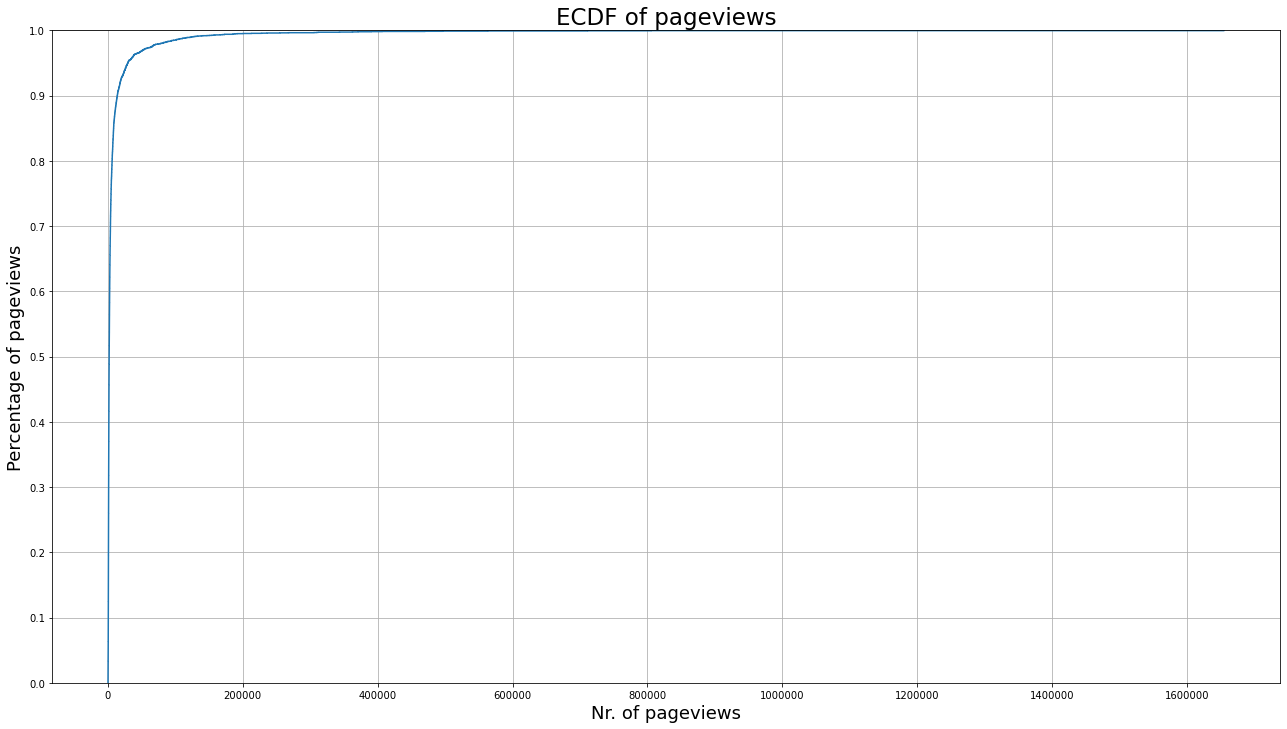

In [44]:
# Print ECDF (Empirical Cumulative Distribution Functions)

fig, ax = plt.subplots(1, figsize=(22, 12))
sns.ecdfplot(data=df, x='pageviews')
ax.set_xlabel("Nr. of pageviews", fontsize=18)
ax.set_ylabel("Percentage of pageviews", fontsize=18)
ax.set_title('ECDF of pageviews', fontsize=23)
plt.ticklabel_format(style='plain') # disable scientific notation
plt.locator_params(axis='both', nbins=15) # setting the number of ticks
plt.grid()
plt.show()

### Task 1.6
**Discuss:** why is it hard to visualize the distribution in the above ECDF plot?

It might be hard to read the empirical cumulative distribution function of page view values among individuals, because over 90% of individuals have less views than 200'000 and there is a very few number of individuals that have an extremely big number of pageviews.

### Task 1.7

Re-do the above CDF plot using a log scale for both the x-axis and the y-axis. Additionally, plot vertical lines that indicate the distribution's arithmetic and geometric means.

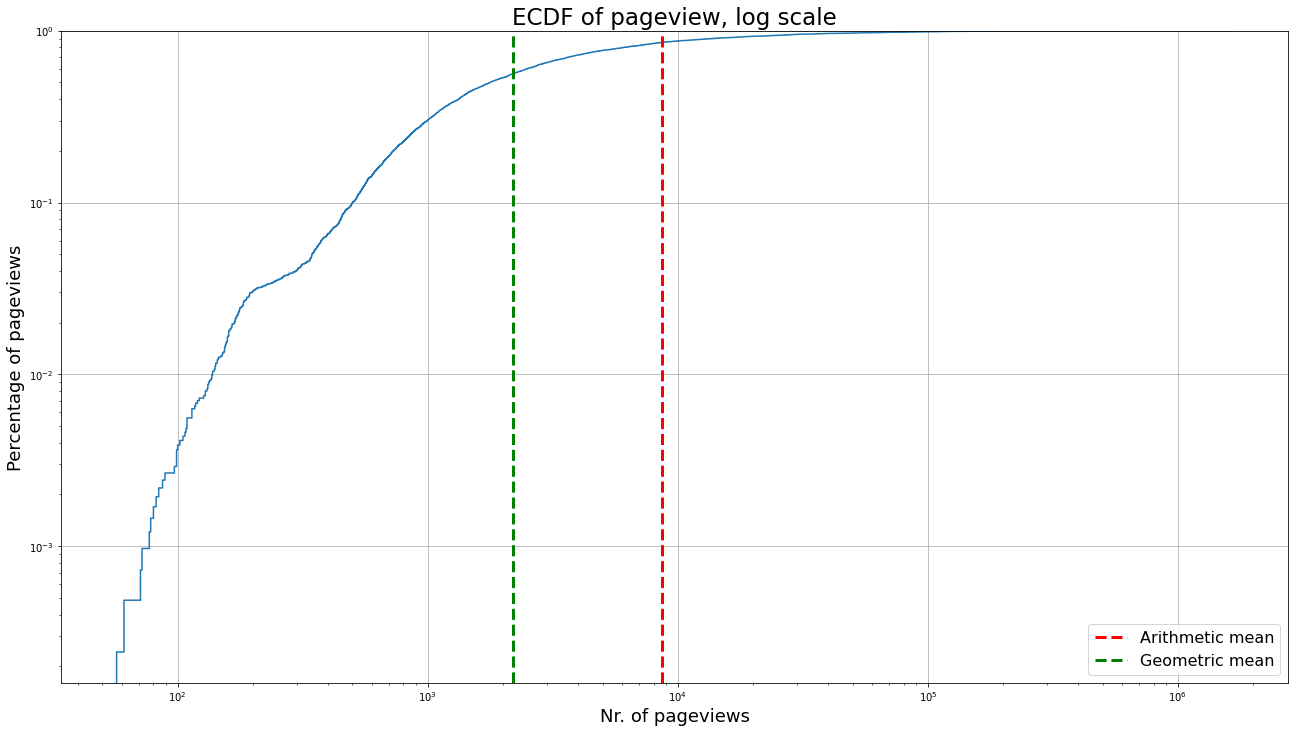

In [52]:
# Calculate arithmetic mean
arithmetic_mean = df.pageviews.mean()
# Calculate geometric mean
geometric_mean = gmean(df.pageviews)

fig, ax = plt.subplots(figsize=(22, 12))

ax = sns.ecdfplot(df.pageviews, log_scale=(True, True))

ax.set(title='Empirical cumulative distribution function: Number of pageviews per pageview',xlabel='Number of entries per pageview', ylabel='Percentage of pageviews')

plt.axvline(x=arithmetic_mean, color='red', linestyle='--', linewidth=3, label='Arithmetic mean')
plt.axvline(x=geometric_mean, color='green', linestyle='--', linewidth=3, label='Geometric mean')


ax.set_xlabel("Nr. of pageviews", fontsize=18)
ax.set_ylabel("Percentage of pageviews", fontsize=18)
ax.set_title('ECDF of pageview, log scale', fontsize=23)

plt.legend(fontsize=16, loc="lower right");

plt.grid()
plt.show()

### Task 1.8

**Discuss:** Visually, does it look like the distribution is a power law?


No. If this distribution were a power law, then after applying log-log axis scale we would see a linear plot.

### Task 1.9

Estimate the 95% confidence intervals of the geometric mean and the arithmetic mean of pageviews using bootstrap resampling.

In [55]:
def create_confidence_interval(data, function):
    ''' 
    Estimates the 95% confidence intervals for function applied 
    on data using bootstrap resampling.
    '''
    #convert array to sequence
    data = (data,)

    #calculate 95% bootstrapped confidence interval for function
    bootstrap_ci = bootstrap(data, function, confidence_level=0.95,
                             random_state=1, method='percentile')

    return bootstrap_ci.confidence_interval

In [56]:
# Confidence interval arithmetic mean
create_confidence_interval(df.pageviews.values, np.mean)

ConfidenceInterval(low=7498.8497210768855, high=10028.941474654377)

In [57]:
# Confidence interval geometric mean
create_confidence_interval(df.pageviews.values, gmean)

ConfidenceInterval(low=2093.9605343949647, high=2278.3593073681377)

### Task 1.10

**Discuss:** What advantages does the geometric mean have over the arithmetic mean to summarize the distribution?

Advantage of geometric mean over arithmetic mean is that it is less affected by extreme values in a skewed distribution. Thus the confidence interval is less wide when using geometric mean as a statistics for this distribution with extreme values.

## Task 2 — 20 pts

Next, investigate the question posed by Mr. Ogane. *Why do so many Tokyo FC players have birthdays in the same month?* 
Here you will not look specifically at Tokyo FC players, but more generally at the birthdays of the athletes in the dataset you have explored in Task 1

In [66]:
birth_per_month = np.array([
0.08118368,0.08148065, 0.08182577, 0.07982728, 0.08301363,
0.08422556, 0.08518067, 0.08925791, 0.08635247, 0.08460279,
0.08258825, 0.08046134
])

### Task 2.1

Calculate and plot the distribution of births (among the athletes contained in the Wikipedia dataset) over months, i.e., what percentage of births happen in January, February, etc.

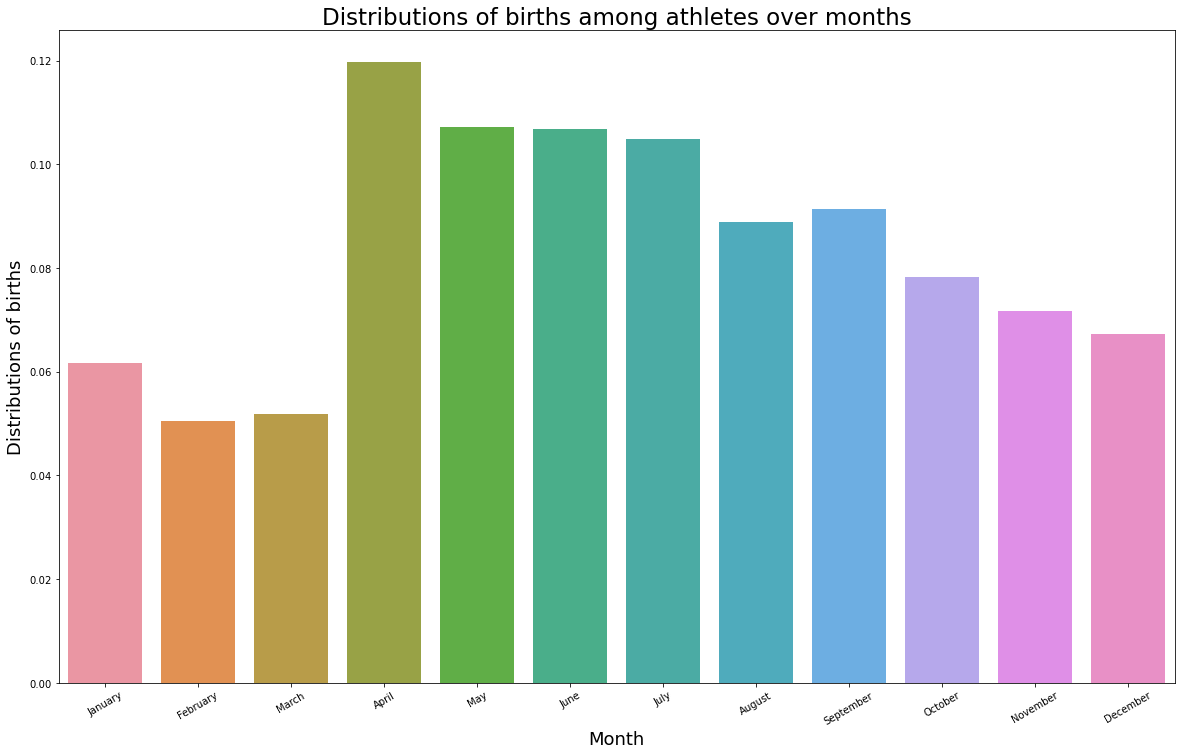

In [69]:
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fig, ax = plt.subplots(figsize=(20, 12))
birth_per_month_df = df.birthdate.apply(lambda x: x.strftime('%B')).value_counts().reindex(months_order)
birth_per_month_df = birth_per_month_df/birth_per_month_df.sum()  # calculate percentage
sns.barplot(x=birth_per_month_df.index, y=birth_per_month_df.values); 

ax.set_xlabel("Month", fontsize=18)
ax.set_ylabel("Distributions of births", fontsize=18)
ax.set_title('Distributions of births among athletes over months', fontsize=23)
plt.xticks(rotation=30);
plt.show()

### Task 2.2

Puzzled with the results, you use census data to retrieve the percentage of births happening each month (this is given to you in an array below). Plot this distribution.

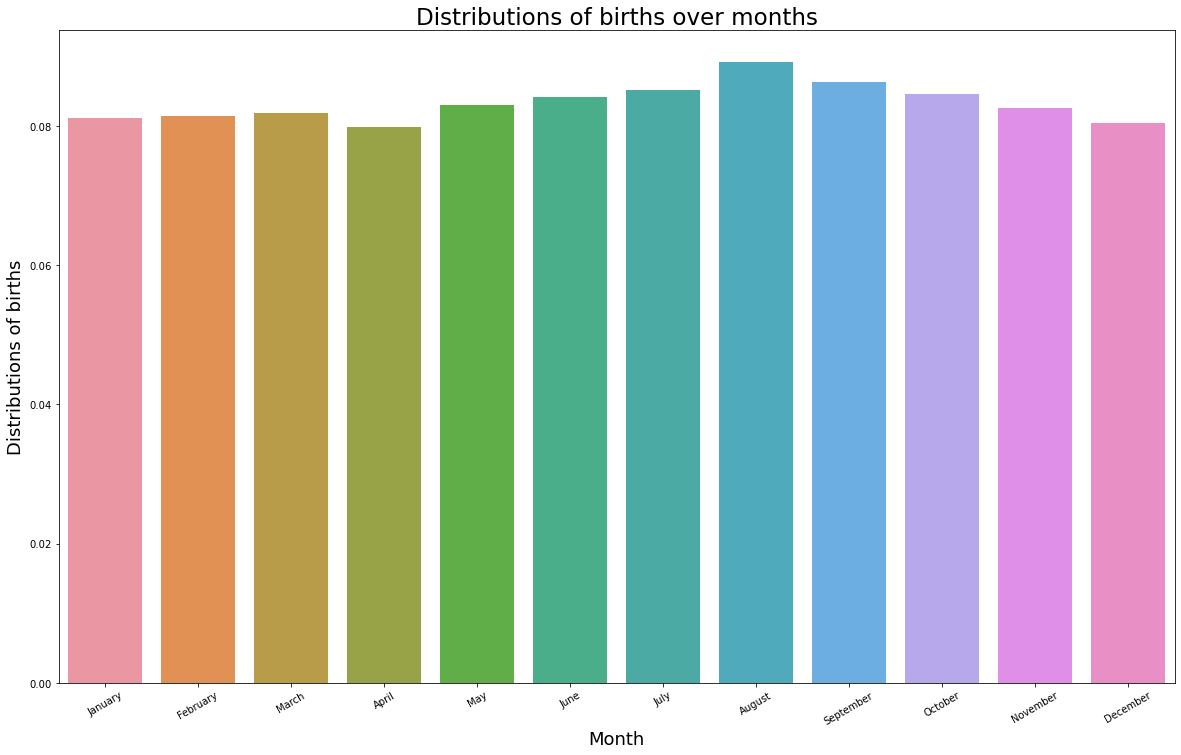

In [70]:
fig, ax = plt.subplots(figsize=(20, 12))

sns.barplot(x=months_order, y=birth_per_month); 

plt.xticks(rotation=30);
ax.set_xlabel("Month", fontsize=18)
ax.set_ylabel("Distributions of births", fontsize=18)
ax.set_title('Distributions of births over months', fontsize=23)
plt.xticks(rotation=30);
plt.show()

### Task 2.3

**2.3** **Discuss:** what is different between the distributions you ploted in **2.1** and **2.2**

Two distributions, the one plotted in 2.1 and 2.2, are different. Data from census is almost perfectly uniformly distributed. Month birthrate of athletes may suggest that they are less likely to be born between January and March, and more likely to be born between April and July.

### Task 2.4

After discussing with your colleagues at work, a theory comes to your mind: school in Japan starts in April. Children who were born between April 1 and March 31 of the following year are placed within the same grade. Therefore, you suspect that the observed pattern may have something to do with when students start school.

Considering that students in Japanese schools have the same birth distribution over the months of the year as the overall Japanese population, i.e., the `birth_per_month` array that was provided to you, calculate:

- For students born in April, how many months older are they than the average student in their grade?
- For students born in March, how many months younger are they than the average student in their grade?

In [73]:
average_month = 0

# Since we are given the distribution, we are computing a
# weighted average in order to calculate the average month.
for i, distr in enumerate(birth_per_month):
    average_month += (i + 1) * distr

# Since the sum of weights is 1, we don't need to divide the obtained
# sum.
print("Average month is: {}".format(months_order[int(average_month)]))

print("April students are {} months older.".format(int(average_month) - 4))
print("March students are {} months younger.".format(3 + 12 - int(average_month)))

Average month is: July
April students are 2 months older.
March students are 9 months younger.


### Task 2.5

**Discuss:** Considering your common sense and the results obtained from the simulation: what advantage do students born in April have over those born in March? How may this affect their odds of becoming professional athletes?

There might be several reasons why students born in April might be considered as having an advantage in becoming professional athletes. Being almost one-year bigger than their colleagues from January-March means an added physical advantage: Older players are more physically developed which means that they are naturally faster, stronger, taller. This tranlsates into a performance advantage in most popular sports. Hence, they might be given priority in an athlete selection, while relatively younger players who might be overlooked.

Older students also might have started their athlete training earlier, since some classes might have some age restrictions. This means that they might have almost one year in advance in training than their March collegues, which definitely can have its toll.

## Task 3 — 20 pts

You report your findings to Mr. Ogane, who receives them with great interest. He asks you: *is there a causal effect between being older than your peers and becoming a Wikipedia-famous athlete?* (Here, “Wikipedia-famous” refers to those individuals notable enough to have made it into English Wikipedia.)

### Task 3.1

**3.1** Create a new column in the dataframe called `date_diff` representing the distance between the athlete's birthdate and the cutoff date of his school class.
- For individuals born in April, May, June, July, August, and September: The distance should be positive and represent the number of days between the birthdate and the previous April 1. For example, if someone is born on April 1, the distance is 0, if someone is born on April 10, the distance is 9, etc.
- For individuals born in October, November, December, January, February, and March: The distance should be negative and represent the number of days between the following April 1 and the birthdate. For example, if someone is born on March 31, the distance is -1; if someone is born on March 27, the distance is -5.
- Print the `date_diff` for the athletes with ids:  `20639249` and `58982155`.

In [4]:
# Compute a reference DataFrame, containing 
# the corresponding 1st of April for the same birthyear of each player
referencedf = pd.DataFrame()
referencedf['year'] = df.birthdate.dt.year
referencedf['month'] = 4
referencedf['day'] = 1
reference = pd.to_datetime(referencedf)

In [5]:
# Compute the distance for April, May, June, July, August, and September
df.loc[df.birthdate.dt.month.isin([4, 5, 6, 7, 8, 9]), 'date_diff'] = (df.birthdate - reference).dt.days

# Compute the distance for January, February and March
df.loc[df.birthdate.dt.month.isin([1, 2, 3]), 'date_diff'] = -(reference - df.birthdate).dt.days

# For Octomber, Novenver and December the following 1st April 
# is in the next year to the birthyear, so a new refference is computed
referencedf['year'] = df.birthdate.dt.year + 1
reference = pd.to_datetime(referencedf)

# Compute the distance for Octomber, Novenver and December
df.loc[df.birthdate.dt.month.isin([10, 11, 12]), 'date_diff'] = -(reference - df.birthdate).dt.days

In [106]:
df[df['id'].isin([20639249, 58982155])][['id', 'date_diff']]

,id,date_diff
2,20639249,-24.0
4120,58982155,6.0


### Task 3.2

**3.2** Create three numpy arrays `x`, `y`, and `ind` all of size 360.
- `x` should contain the integers between -180 and 179 (-180 and 179 inclusive).
- `y` should contain the percentage of athletes born with a `date_diff` equal to the corresponding value of `x`.
- `ind` should contain 0 if `x` is smaller than zero and 1 if `x` is bigger or equal to zero.

In [6]:
x = np.array([i for i in range(-180, 180)])
y = np.array([df[df.date_diff == i].id.count() * 100 / len(df.values) for i in range(-180, 180)])
ind = (x >= 0).astype(int)   

In [7]:
print(x)

[-180 -179 -178 -177 -176 -175 -174 -173 -172 -171 -170 -169 -168 -167
 -166 -165 -164 -163 -162 -161 -160 -159 -158 -157 -156 -155 -154 -153
 -152 -151 -150 -149 -148 -147 -146 -145 -144 -143 -142 -141 -140 -139
 -138 -137 -136 -135 -134 -133 -132 -131 -130 -129 -128 -127 -126 -125
 -124 -123 -122 -121 -120 -119 -118 -117 -116 -115 -114 -113 -112 -111
 -110 -109 -108 -107 -106 -105 -104 -103 -102 -101 -100  -99  -98  -97
  -96  -95  -94  -93  -92  -91  -90  -89  -88  -87  -86  -85  -84  -83
  -82  -81  -80  -79  -78  -77  -76  -75  -74  -73  -72  -71  -70  -69
  -68  -67  -66  -65  -64  -63  -62  -61  -60  -59  -58  -57  -56  -55
  -54  -53  -52  -51  -50  -49  -48  -47  -46  -45  -44  -43  -42  -41
  -40  -39  -38  -37  -36  -35  -34  -33  -32  -31  -30  -29  -28  -27
  -26  -25  -24  -23  -22  -21  -20  -19  -18  -17  -16  -15  -14  -13
  -12  -11  -10   -9   -8   -7   -6   -5   -4   -3   -2   -1    0    1
    2    3    4    5    6    7    8    9   10   11   12   13   14   15
   16 

In [109]:
print(y)

[0.43657531 0.38806694 0.41232113 0.31530439 0.24254184 0.29105021
 0.16977929 0.1455251  0.1455251  0.24254184 0.19403347 0.24254184
 0.21828765 0.36381276 0.21828765 0.24254184 0.26679602 0.26679602
 0.12127092 0.31530439 0.21828765 0.24254184 0.1455251  0.33955857
 0.12127092 0.31530439 0.19403347 0.16977929 0.29105021 0.1455251
 0.1455251  0.12127092 0.24254184 0.29105021 0.24254184 0.26679602
 0.31530439 0.19403347 0.29105021 0.19403347 0.24254184 0.29105021
 0.12127092 0.16977929 0.24254184 0.24254184 0.19403347 0.21828765
 0.24254184 0.53359204 0.46082949 0.1455251  0.19403347 0.31530439
 0.1455251  0.21828765 0.29105021 0.31530439 0.24254184 0.24254184
 0.19403347 0.21828765 0.24254184 0.12127092 0.26679602 0.48508368
 0.19403347 0.24254184 0.26679602 0.12127092 0.12127092 0.29105021
 0.12127092 0.09701674 0.21828765 0.19403347 0.26679602 0.19403347
 0.1455251  0.29105021 0.33955857 0.12127092 0.19403347 0.16977929
 0.24254184 0.24254184 0.29105021 0.19403347 0.1455251  0.16977

In [110]:
print(ind)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### Task 3.3

**3.3** Estimate the following linear regression: `y ~ x + ind` using `statsmodels`. Report the summary of the model.

In [8]:
training_df = pd.DataFrame()
training_df['x'] = x
training_df['y'] = y
training_df['ind'] = ind

mod = smf.ols(formula='y ~ x + C(ind)', data=training_df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     118.8
Date:                Thu, 01 Dec 2022   Prob (F-statistic):           2.87e-40
Time:                        22:57:45   Log-Likelihood:                 361.31
No. Observations:                 360   AIC:                            -716.6
Df Residuals:                     357   BIC:                            -705.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1548      0.011     14.696      

### Task 3.4

**3.4** **Discuss:** What does the coefficient associated with the dummy variable `ind` captures in the above regression?

The coefficient associated with ind captures the fact that days between 1st of April and 28 September have on average with ~23% more athletes

### Task 3.5

**3.5** Use the model parameters to estimate the percentage of athletes born on March 31st, i.e., use the intercept ($\beta_0$) and the coefficient associated with `x` ($\beta_1$) and calculate: $\beta_0 - 1 * \beta_1$ (recall that $x$ equals -1 in March 31st).

In [113]:
estimate = res.params['Intercept'] - res.params['x']  
print("Estimated value: {}".format(estimate))
print("Real Value: {}".format(y[np.where(x == -1)[0][0]]))

Estimated value: 0.15536189430982586
Real Value: 0.1212709192335678


### Task 3.6

**3.6** Use the model parameters to estimate the percentage of athletes born on April 1st.

In [114]:
estimate = res.params['Intercept'] + 0 * res.params['x'] + res.params['ind']
print("Estimated value: {}".format(estimate))
print("Real Value: {}".format(y[np.where(x == 0)[0][0]]))

Estimated value: 0.39264791516008624
Real Value: 0.09701673538685424


### Task 3.7

**3.7** **Discuss:** Drawing from your knowledge of observational studies and the questions answered thus far, respond to Mr. Ogane's question: *is there a causal effect between being older than your peers and becoming a Wikipedia-famous athlete?* Explain whether the evidence you have obtained is convincing and why.

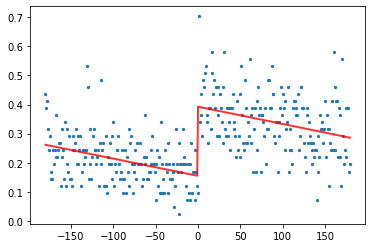

In [116]:
coefficients = res.params
plt.plot(x, [(coefficients.x * el + coefficients.Intercept + coefficients.ind * ind[i]) for i,el in enumerate(x)], lw =2, alpha=0.8, color='red')
plt.scatter(x,y, s=5)
plt.show()

Even though it appears that there is a causal effect between being older than your peers and becoming a Wikipedia-famous athlete (since there appears to be more athletes with ind > 1) there might be some potential confounds that can influence this result. Some confounds can be ambition, natural talent, determination, family's wealth and support, effort, sport promoting among children, popularity of a sport etc. Further investigations need to be done in order to validate this result.  

## Task 4 — 20 pts

You return to Mr. Ogane with your findings, which he again receives with great interest. The sharp manager, however, asks a question that ignites your curiosity: *are athletes that are born right after the school cut-off date (i.e., in April or May) simply better?**

To understand if that is the case, you come up with a plan: the number of pageviews received by a Wikipedia page is a good way to differentiate between mildly famous athletes and truly famous ones. Thus you can do a matched analysis comparing athletes born in February or March (right before the cut-off) with athletes born in April or May (right after the cut-off); you should discard all athletes that were not born in one of these four months.

To make matched athletes even more comparable, you will also only consider pairs of athletes that:
1. were born in the same year; 
2. have the same gender; and
3. have the same occupation.

Matching should be done 1-to-1; i.e., each athlete born in February/March should be matched to one and only one athlete born in April/May (there will naturally be some athletes left unmatched).

### Task 4.1

**4.1** Obtain the matched data described in the text above. Report the number of matched pairs and the number of discarded athletes. Your resulting dataframe should contain one row per athlete and an indicator variable `is_after`, which equals 1 when the athlete was born in April or May and 0 otherwise. Note that here you are doing exact matching, and not propensity score matching!

In [9]:
G = nx.Graph()

# We construct a bipartite graph since we have to distinct groups
# we try to match
G.add_nodes_from(df[(df.birthdate.dt.month == 2) | (df.birthdate.dt.month == 3)].id.values, bipartite=0)
G.add_nodes_from(df[(df.birthdate.dt.month == 4) | (df.birthdate.dt.month == 5)].id.values, bipartite=1)

for before_id, before_row in df[(df.birthdate.dt.month == 2) | (df.birthdate.dt.month == 3)].iterrows():
    for after_id, after_row in df[(df.birthdate.dt.month == 4) | (df.birthdate.dt.month == 5)].iterrows():
        if (after_row['birthyear'] == before_row['birthyear']\
            and after_row['gender'] == before_row['gender']\
            and after_row['occupation'] == before_row['occupation']):
            G.add_edges_from([(before_row['id'], after_row['id'])])
            

    

In [10]:
matching = nx.bipartite.maximum_matching(G, top_nodes=df[(df.birthdate.dt.month == 2) | (df.birthdate.dt.month == 3)].id.values)

In [120]:
print("Number of matched pairs is {}".format(len(matching) / 2))

Number of matched pairs is 358.0


In [121]:
nr_discarded = (len(df[(df.birthdate.dt.month == 2) | (df.birthdate.dt.month == 3)].id.values)\
                + len(df[(df.birthdate.dt.month == 4) | (df.birthdate.dt.month == 5)].id.values)\
                -len(matching))
print("Number of discarded athletes is {}".format(nr_discarded))

Number of discarded athletes is 642


In [122]:
nr_discarded_all = len(df) - len(matching)
print("Number of discarded athletes from all dataframe is {}".format(nr_discarded_all))

Number of discarded athletes from all dataframe is 3407


In [12]:
# Create a dataframe only with the matched individuals
match_df = df.loc[df.id.isin(matching.keys())].copy()

match_df['is_after'] = (match_df.birthdate.dt.month >= 4).astype(int)
match_df.head()

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews,date_diff,is_after
5,20641239,Yasuo Takamori,SOCCER PLAYER,M,False,Japan,1934-03-03,1934.0,1047.0,-29.0,0
13,25864538,Kenzo Ohashi,SOCCER PLAYER,M,False,Japan,1934-04-21,1934.0,758.0,20.0,1
21,25864203,Yasuo Haruyama,SOCCER PLAYER,M,False,Japan,1906-04-04,1906.0,935.0,3.0,1
29,733681,Kazuyoshi Miura,SOCCER PLAYER,M,True,Japan,1967-02-26,1967.0,496424.0,-34.0,0
32,19134567,Masahiro Hamazaki,SOCCER PLAYER,M,False,Japan,1940-03-14,1940.0,983.0,-18.0,0


### Task 4.2

**4.2** The number of pageviews is heavy-tailed, as we have seen in Task 1. Create a new column in your matched dataframe containing the natural logarithm of the number of pageviews.

In [13]:
match_df['log_pageviews'] = np.log(match_df.pageviews)
match_df.head()

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews,date_diff,is_after,log_pageviews
5,20641239,Yasuo Takamori,SOCCER PLAYER,M,False,Japan,1934-03-03,1934.0,1047.0,-29.0,0,6.953684
13,25864538,Kenzo Ohashi,SOCCER PLAYER,M,False,Japan,1934-04-21,1934.0,758.0,20.0,1,6.630683
21,25864203,Yasuo Haruyama,SOCCER PLAYER,M,False,Japan,1906-04-04,1906.0,935.0,3.0,1,6.840547
29,733681,Kazuyoshi Miura,SOCCER PLAYER,M,True,Japan,1967-02-26,1967.0,496424.0,-34.0,0,13.115186
32,19134567,Masahiro Hamazaki,SOCCER PLAYER,M,False,Japan,1940-03-14,1940.0,983.0,-18.0,0,6.890609


### Task 4.3

**4.3** Assuming that whether the athlete is born in the two months right before the cutoff (February and March) or the two months right after (April and May) is assigned at random, use a linear regression to estimate the effect of being born after rather than before the cutoff date in the number of pageviews athletes receive. Use the log-transformed value you calculated in **4.2** as the outcome of your model (i.e., the $y$ of the regression). Report the summary of your model.

In [14]:
mod_pageviews = smf.ols(formula='log_pageviews ~ C(is_after)', data=match_df)
res_pageviews = mod_pageviews.fit()
print(res_pageviews.summary())

                            OLS Regression Results                            
Dep. Variable:          log_pageviews   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1158
Date:                Thu, 01 Dec 2022   Prob (F-statistic):              0.734
Time:                        22:58:36   Log-Likelihood:                -1256.0
No. Observations:                 716   AIC:                             2516.
Df Residuals:                     714   BIC:                             2525.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.8205      0.074  

### Task 4.4

**4.4** **Discuss:** Interpret the coefficients obtained from the linear regression.

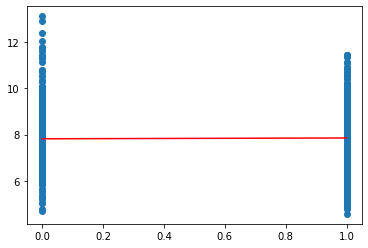

In [19]:
# Plot the datapoints to understand better the coefficients
plt.scatter(match_df.is_after, match_df.log_pageviews)

coefficients = res_pageviews.params

x = [0, 1]
y = [(coefficients.Intercept + el * coefficients['C(is_after)[T.1]']) for el in x]
plt.plot(x, y, color='r')

Having the above parameters we can observe that the slope of the liniar regression is almost 0, which means that the average values from both categories (before and after 1st of April) are almost the same. In other words, the average value for the logarithm of pageviews is almost the same and the average is shown by the intercept. This can mean that being born before or after April has no effect in the number of pageviews an individual has.


### Task 4.5

**4.5** Interpreting the results obtained throughout this homework, create a short text (max. 250 words) where you:
- Present and explain a credible causal diagram capturing the relationship between the variables below, and justify your causal diagram given the questions answered in this homework:
    1. "Skill": an individual's innate talent towards a sport.
    2. "Relative Age": how old an individual was in comparison to his or her peers.
    3. "Success before adulthood": how successful the individual is as an athlete as a child/teenager.
    4. "Success as an adult": how successful the individual is as an athlete as an adult.

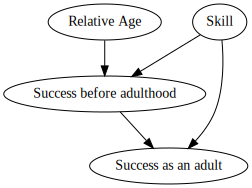

In [28]:
# Draw the causal diagram
sprinkler = CausalGraphicalModel(
    nodes=["Skill", "Relative Age", "Success before adulthood", "Success as an adult", ],
    edges=[
        ("Skill", "Success before adulthood"), 
        ("Skill", "Success as an adult"), 
        ("Success before adulthood", "Success as an adult"),
        ("Relative Age", "Success before adulthood"),
    ]
)

sprinkler.draw()

- **Discuss:** Consider two equally successful children athletes, one born on March 31 and the other on April 1 — which will likely be more successful as an adult? Your answer should be consistent with your causal diagram.

Skill is definitely an extremely important aspect in any sport, influencing both the Success before adulthood and success as an adult. Sport is all about obtaining performant results, so the amount of skill an individual posses directly influence his/her success throughtout the entire career.

Success before adulthood can influence succes as an adult because, in this way, the individual might have access to a better pool of instructors, coaches, might be part of a better team with a better budget to invest in his/her training, better training facilities. Success before adulthood might also be a good indicator on the motivation and focus of that individual, which will definitely be helpful on the long run.

As we have seen in task 2.5, the relative age might influence the physical development of the individual, which can translate in increased speed, strength, mental focus, all of them playing a vital role in the individuals performance, especially when we are talking about children and teenagers, when there is a huge difference from one year to another. This is why relative age can influence success before adulthood. However, relative age does not directly influece success as an adult. We can take pageviews as an indicator of the success of an adult and we have seen in task 4.4 that no matter when the individual was born, the mean of the log of pageviews was almost the same. This suggests that relative age does not dirrectly influence succes as an adult.





**Discussion**: Comparing two equally successful children athletes, one born on March 31 and the other on April 1, we cannot say which one would be more succesfull based on the realtive age. As we have explained above, relative age can influence the success before adulthood but since they are equally succesfull as children, relative age does not play a role anymore. In this case, only skill can determine which one of them will be more succesfull in the future.

## Task 5 — 20 pts

Your findings in Task 4 provide important information for Tokyo FC to scout for young athletes. However, Mr. Ogane points out that other countries have messier cut-off dates for school (e.g., in the U.S., it varies widely by state), and thus the results may be less applicable to other countries.

While you could investigate specific cut-off dates per country, you decide to first use your machine learning skills to get a sense of how promising your efforts might turn out to be. This is made easy as you find an extended version of the dataset you've been working on so far, which contains data about all Wikipedia biographies all around the world

In [133]:
athlete_categories = {
    'ATHLETE',
    'BASKETBALL PLAYER',
    'BOXER',
    'CYCLIST',
    'GYMNAST',
    'HANDBALL PLAYER',
    'HOCKEY PLAYER',
    'SKATER',
    'SKIER',
    'TENNIS PLAYER',
    'SOCCER PLAYER',
    'SWIMMER',
    'WRESTLER'
}

### Task 5.1

**5.1**Load the dataset containing data about Wikipedia-famous individuals into memory using pandas. You should load the data directly from the compressed file. Then, print the first few lines of the dataset.

In [134]:
all_df = pd.read_csv(os.path.join(DATA_DIR, ALL_ATHLETES_FILENAME), compression='gzip', parse_dates=['birthdate'])
all_df.head()

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews
0,4848272,Donald Trump,POLITICIAN,M,True,United States,1946-06-14,1946.0,10221172.0
1,13623554,Che Guevara,SOCIAL ACTIVIST,M,False,Argentina,1928-06-14,1928.0,3660108.0
2,1687680,Pope Francis,RELIGIOUS FIGURE,M,True,Argentina,1936-12-17,1936.0,3893767.0
3,21492751,Nelson Mandela,SOCIAL ACTIVIST,M,False,South Africa,1918-07-18,1918.0,4359499.0
4,63747,Muhammad Ali,BOXER,M,False,United States,1942-01-17,1942.0,3940228.0


### Task 5.2

**5.2** Create two columns in this dataframe:
- `is_athlete` an indicator variable which equals 1 if the occupation of an individual is related to a sport (you are provided with a list below) and 0 otherwise.
- `dayofyear` an integer between 1 and 366 indicating on which day of the year the individual was born.

In [137]:
all_df['is_athlete'] = all_df.occupation.isin(athlete_categories).astype(int)
all_df['dayofyear'] = all_df.birthdate.dt.dayofyear
all_df.head()

,id,name,occupation,gender,alive,bplace_country,birthdate,birthyear,pageviews,is_athlete,dayofyear
0,4848272,Donald Trump,POLITICIAN,M,True,United States,1946-06-14,1946.0,10221172.0,0,165
1,13623554,Che Guevara,SOCIAL ACTIVIST,M,False,Argentina,1928-06-14,1928.0,3660108.0,0,166
2,1687680,Pope Francis,RELIGIOUS FIGURE,M,True,Argentina,1936-12-17,1936.0,3893767.0,0,352
3,21492751,Nelson Mandela,SOCIAL ACTIVIST,M,False,South Africa,1918-07-18,1918.0,4359499.0,0,199
4,63747,Muhammad Ali,BOXER,M,False,United States,1942-01-17,1942.0,3940228.0,1,17


### Task 5.3

**5.3** For each country:
- Create a training set with 80% of the individuals and a test set with the remaining 20%;
- Train a random forest model (using `sklearn`, you can use the default parameters) to predict whether an individual is an athlete or not based on: 1) the day of the year they were born `dayofyear`; 2) the year they were born (e.g., 1964, year should be a numerical variable) and 3) their gender.
- report the precision of your classifier for each country.

In [139]:
# Split the dataset in train and test set for each country
train = {}
test = {}


for country in all_df.bplace_country.unique():
    # Select only the targeted columns
    country_df_X = all_df[all_df.bplace_country == country][['dayofyear', 'birthyear', 'gender']]
    # Convert gender labels into 0/1 labels
    country_df_X['gender'] = (country_df_X['gender'] == 'M').astype(int)
    # Get the is_athlete label
    country_df_Y = all_df[all_df.bplace_country == country]['is_athlete']
    
    X_train, X_test, y_train, y_test = train_test_split(country_df_X, country_df_Y, test_size=0.2, random_state=42)

    train[country] = (X_train, y_train)
    test[country] = (X_test, y_test)

In [141]:
precision = {}
clfs = {}
preds = {}

for country in all_df.bplace_country.unique():
    clf = RandomForestClassifier()
    clf.fit(train[country][0], train[country][1])
    
    # Save the corresponding classifier for each country
    clfs[country] = clf
    
    # Predict for the test set
    y_pred = clf.predict(test[country][0])
    
    # Save the predictions for each country
    preds[country] = y_pred
    
    # Calculate the precision for each country
    precision[country] = precision_score(test[country][1], y_pred)

In [144]:
print(tb.tabulate(list(precision.items()), headers=["Country", "Precision"]))

Country                   Precision
----------------------  -----------
United States              0.330033
Argentina                  0.751938
South Africa               0.842105
Spain                      0.817778
Mexico                     0.689655
United Kingdom             0.562232
Poland                     0.770833
Russia                     0.651613
Brazil                     0.897351
France                     0.733333
Germany                    0.633065
Romania                    0.644444
India                      0.333333
Italy                      0.696296
Ukraine                    0.666667
Japan                      0.891278
China                      0.725
Belgium                    0.722222
Czechia                    0.753846
Austria                    0.807692
Sweden                     0.719512
Iran                       0.913043
Netherlands                0.747826
Hungary                    0.634615
Serbia                     0.732143
Portugal                   0.87

### Task 5.4

**5.4** Estimate the percentage of `athlete` individuals per country (simply by counting in the data).

In [145]:
# Get the percentage of athletes for each country
athletes_percent = all_df[all_df.is_athlete == 1].groupby(by='bplace_country').id.count() * 100 / all_df.groupby(by='bplace_country').id.count()

In [148]:
print(tb.tabulate(zip(athletes_percent.index, athletes_percent.loc[athletes_percent.index]), headers=["Country", "Percentage of Athletes"]))



Country                   Percentage of Athletes
----------------------  ------------------------
Argentina                               72.838
Australia                               51.7493
Austria                                 52.7027
Belgium                                 61.5809
Bosnia and Herzegovina                  57.1429
Brazil                                  83.1126
Canada                                  30.8157
China                                   38.1982
Croatia                                 73.012
Czechia                                 64
Denmark                                 57.1111
Finland                                 50.2688
France                                  45.8022
Germany                                 49.793
Greece                                  52.1569
Hungary                                 50.7282
India                                    5.53592
Iran                                    40.4167
Ireland                                 29.47

### Task 5.5

**5.5** **Discuss:** how can the results from **5.4** impact the metric (precision) used in **5.3**? What could be a better suited metric to use here?

In [149]:
# Aggregate all the data into a dataframe per country
stats_per_country = pd.DataFrame()

# Add the atletes percentage
stats_per_country['athlete_percent'] = athletes_percent

# Add precision percentage
stats_per_country['precision'] = stats_per_country.index.map(precision)
stats_per_country['precision'] = 100 * stats_per_country['precision']

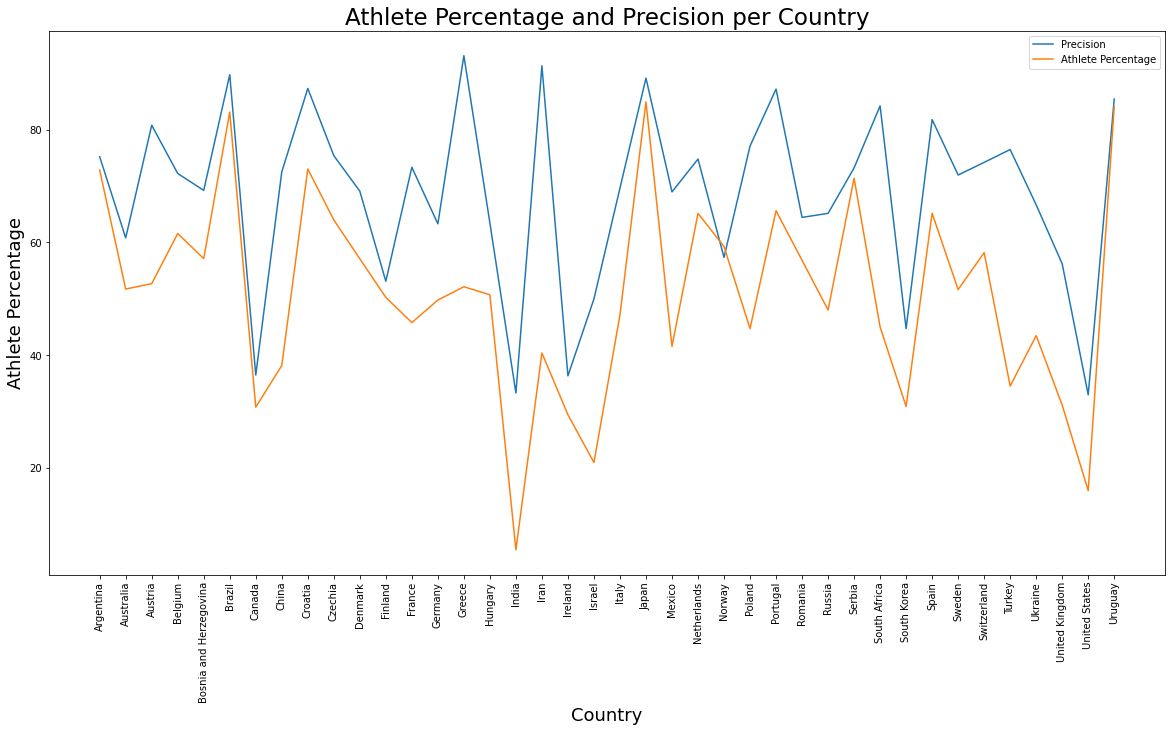

In [151]:
# Plot the precision and athletes percentage per country
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=stats_per_country, x=stats_per_country.index, y='precision', label='Precision')
sns.lineplot(data=stats_per_country, x=stats_per_country.index, y='athlete_percent', label='Athlete Percentage')
ax.set_xlabel("Country", fontsize=18)
ax.set_ylabel("Athlete Percentage", fontsize=18)
ax.set_title('Athlete Percentage and Precision per Country', fontsize=23)
plt.xticks(rotation=90)
plt.show()

We can see from the graph that athlete percentage tends to follow the athletes percentage. The athles percentage also indicates that the sets are highly imbalanced (there are some countries with a really hight athletes percentage:Japan, Brazil and some countries with a really low percentage India, United States). We can also observe that in general, athletes percentage is over 50% for most countries.

Because we are dealing with an imbalanced set, we need another metric that could capture this. We can use a Macro F1-score.



### Task 5.6

**5.6** Repeat the procedure done in **5.3**, but now calculate the metric you proposed in **5.5**.

In [154]:
f1 = {}

for country in all_df.bplace_country.unique():
    f1[country] = f1_score(test[country][1], preds[country], average='macro')
stats_per_country['f1score'] = stats_per_country.index.map(f1)
stats_per_country['f1score'] = 100 * stats_per_country['f1score']

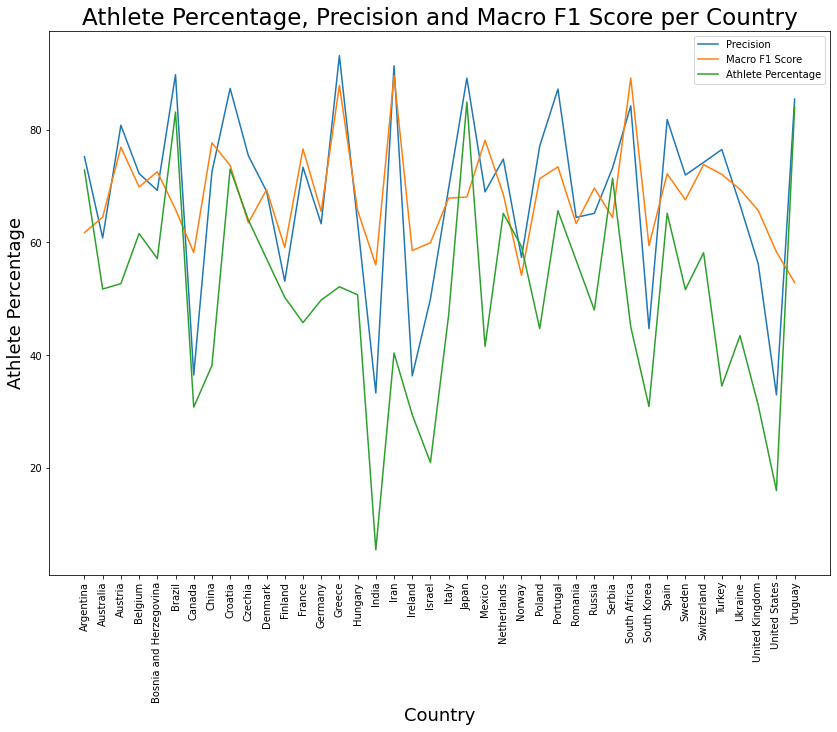

In [156]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.lineplot(data=stats_per_country, x=stats_per_country.index, y='precision', label='Precision')
sns.lineplot(data=stats_per_country, x=stats_per_country.index, y='f1score', label='Macro F1 Score')
sns.lineplot(data=stats_per_country, x=stats_per_country.index, y='athlete_percent', label='Athlete Percentage')
ax.set_xlabel("Country", fontsize=18)
ax.set_ylabel("Athlete Percentage", fontsize=18)
ax.set_title('Athlete Percentage, Precision and Macro F1 Score per Country', fontsize=23)
plt.xticks(rotation=90)
plt.show()

### Task 5.7

**5.7** **Discuss:** according to this analysis, in which other countries might you be able to use the date of birth to recruit good athletes? Justify.

In [158]:
stats_per_country[stats_per_country['f1score'] > 75].index

Index(['Austria', 'China', 'France', 'Greece', 'Iran', 'Mexico',
       'South Africa'],
      dtype='object', name='bplace_country')

According to the obtained analysis, countries where it would be good to use the date of birth to recruit good athletes are 'Austria', 'China', 'France', 'Greece', 'Iran', 'Mexico','South Africa because they have obtained really good F1 score for the training set. We set a threshold of 75%, since we thought it would be high enough to reflect a performant model.

The graph above showcase that while for some countries the date of birth could be a really good indicator of an athletes capabilities, for other the obtained F1 score is not that high.